## Credit Card Fraud Detection Project - COMP 379/479 Machine Learning
Ololade Akinsanola, Oliver Schramm, Eric Spencer, Tigist Tefera, and Avery Walker

# Data Download


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from imblearn.over_sampling import SMOTE
from collections import Counter
import xgboost

In [2]:
# 1. Install Kaggle CLI
!pip install kaggle

# 2. Write your credentials to ~/.kaggle/kaggle.json
import os, json

# Ensure the directory exists
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Hard‑coded credentials, overloading this key only hurts kaggle, no skin off my back
creds = {
    "username": "ericspencer00",
    "key": "1599fe6adf987aa5f403f97df7be75e7"
}

# Write and secure the file
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(creds, f)
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

# 3. Point Kaggle CLI at that folder
os.environ["KAGGLE_CONFIG_DIR"] = os.path.expanduser("~/.kaggle")

# 4. Download & unzip the dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud -p . --unzip

# 5. Load into pandas
import pandas as pd
data = pd.read_csv("creditcard.csv")
print("Data downloaded successfully.")
print(data.head())


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
Data downloaded successfully.
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647

## Basic Info + Data Visualizations


In [3]:
print(data.info())
print(data.head())
# Check the class distribution
print(data["Class"].value_counts())  # 0 = Non-fraud, 1 = Fraud

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Basic info:
- There are some null values we account for later
- SMOTE will be useful for classification
- V1-V28 are anonymized PCA components, we can use feature importance to see which ones matter most

Class
0    284315
1       492
Name: count, dtype: int64


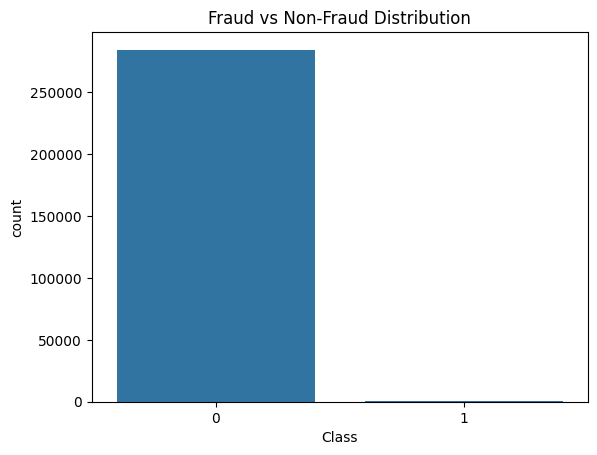

In [4]:
sns.countplot(x='Class', data=data)
print(data["Class"].value_counts())
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

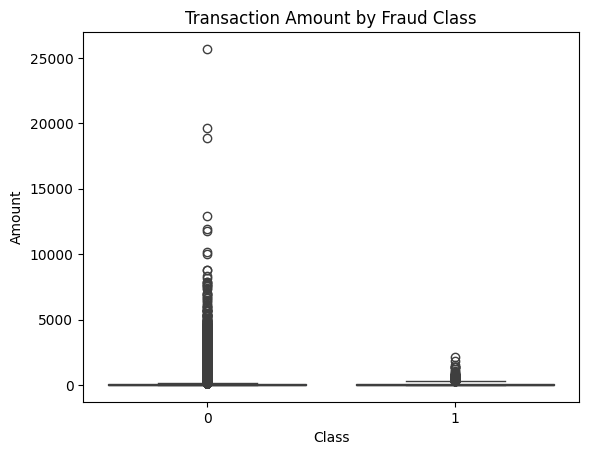

In [5]:
sns.boxplot(x='Class', y='Amount', data=data)
plt.title("Transaction Amount by Fraud Class")
plt.show()

This shows we can potentially eliminate any classifications for fraud past ~2000 transactions

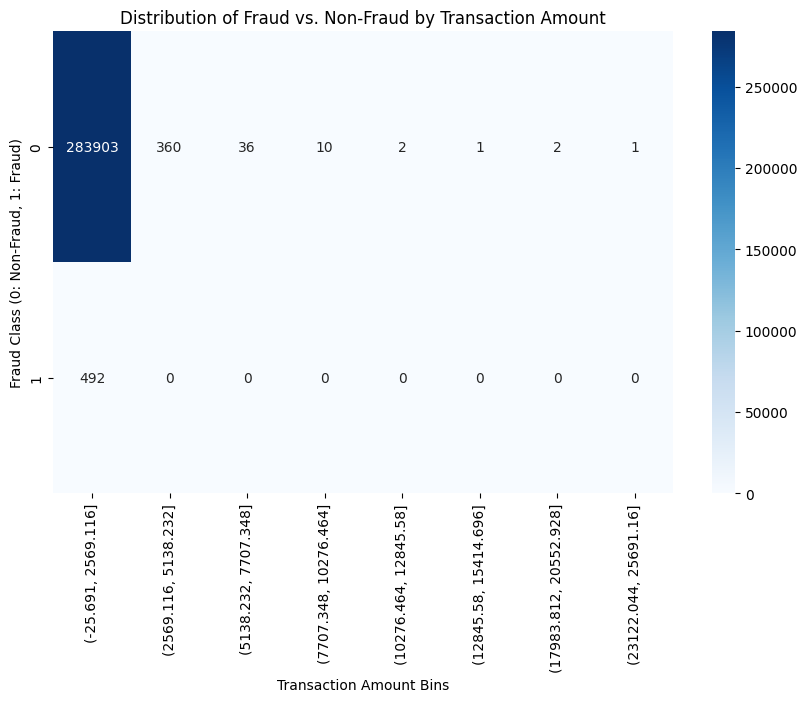

In [6]:
# Create a heatmap to visualize the distribution
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(data['Class'], pd.cut(data['Amount'], bins=10)), annot=True, fmt='d', cmap='Blues')
plt.title('Distribution of Fraud vs. Non-Fraud by Transaction Amount')
plt.xlabel('Transaction Amount Bins')
plt.ylabel('Fraud Class (0: Non-Fraud, 1: Fraud)')
plt.show()

Distribution of transaction amount

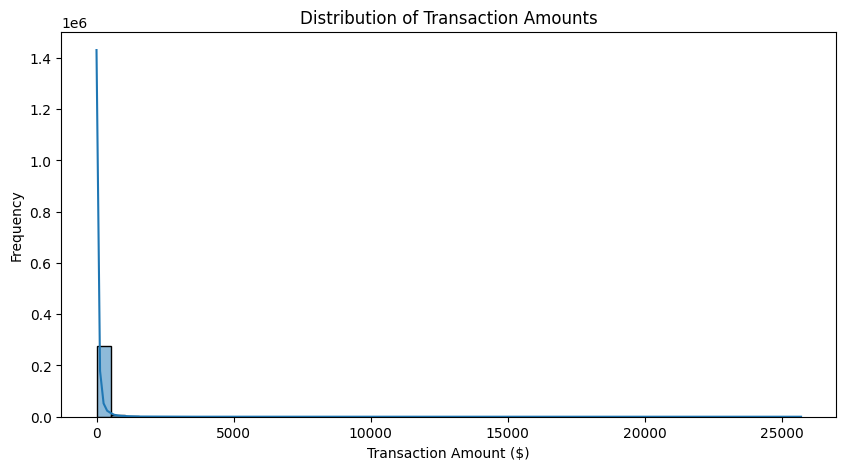

In [7]:
plt.figure(figsize=(10,5))
sns.histplot(data["Amount"], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Transaction Amount ($)")
plt.ylabel("Frequency")
plt.show()

A majority of the transactions are very low (close to zero)
There are very few high-value transactions.
Fraudulent transactions usually involve very high-values or unusual amounts of purchases.

Features Correlation plot

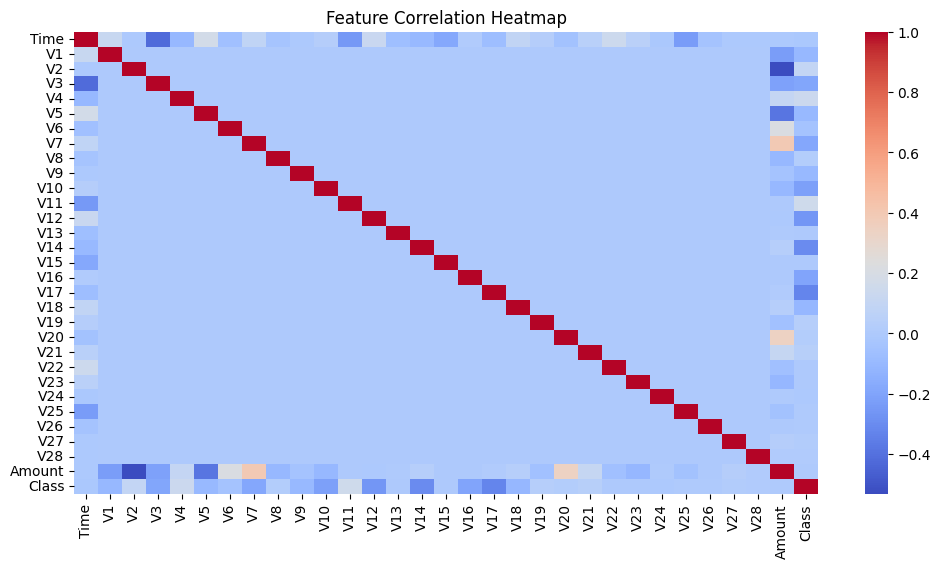

In [8]:
plt.figure(figsize=(12,6))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

This graph represents features that have a higher correlation marked red, lower correlation marked light blue and negative correlation marked blue


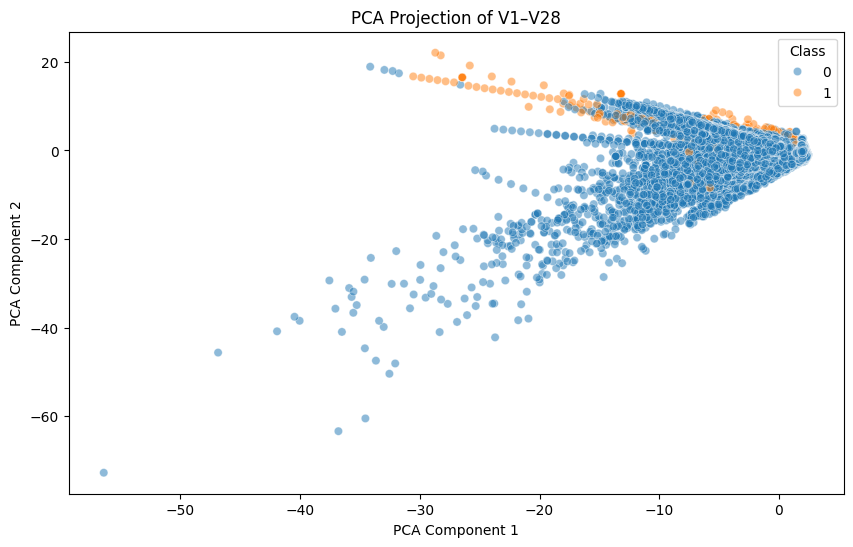

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features = [f'V{i}' for i in range(1, 29)]
X = data[features]
y = data['Class']

# drop all NaN values
X = X.dropna()
y = y.dropna()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, alpha=0.5)
plt.title('PCA Projection of V1–V28')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

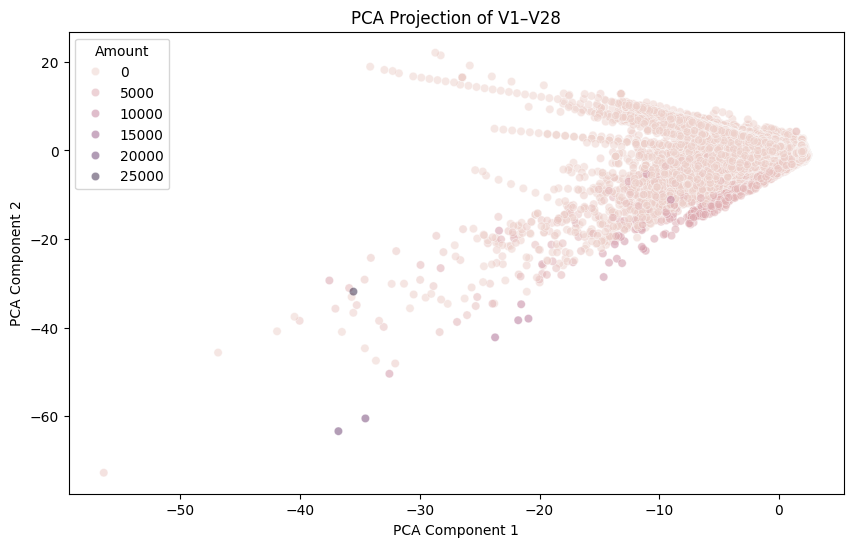

In [10]:
# Visualize how this PCA matches up with our $ values
amount_values = data.loc[X.index, 'Amount']

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=amount_values, alpha=0.5)
plt.title('PCA Projection of V1–V28')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

Consider using t-SNE or UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


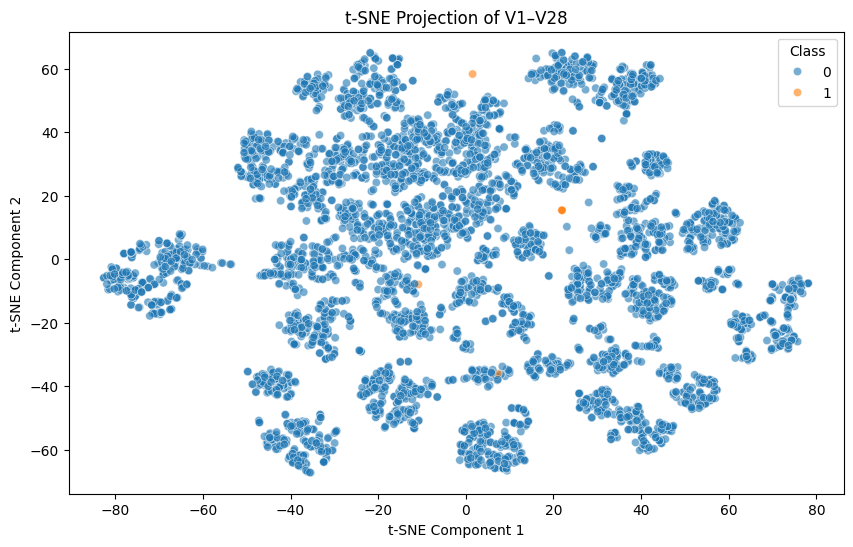

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Sample to speed up t-SNE (adjust size as needed)
sampled_data = data.sample(n=5000, random_state=42)
features = [f'V{i}' for i in range(1, 29)]
X = sampled_data[features]
y = sampled_data['Class']

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X)

# Visualize
tsne_df = pd.DataFrame({'TSNE1': X_tsne[:, 0], 'TSNE2': X_tsne[:, 1], 'Class': y.values})
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Class', alpha=0.6)
plt.title('t-SNE Projection of V1–V28')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


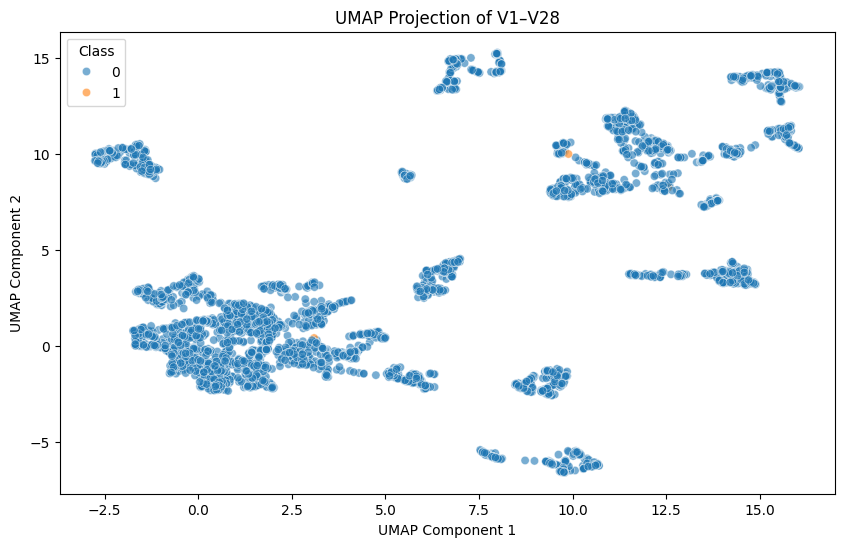

In [12]:
import umap.umap_ as umap

# Use the same sampled data
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# Visualize
umap_df = pd.DataFrame({'UMAP1': X_umap[:, 0], 'UMAP2': X_umap[:, 1], 'Class': y.values})
plt.figure(figsize=(10, 6))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Class', alpha=0.6)
plt.title('UMAP Projection of V1–V28')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

I don't believe either of these will be as helpful.

# Split data

In [13]:
# split the data between test and train, drop all NaN values
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X = data.drop('Class', axis=1)
# y = data['Class']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.isna().sum())
print(y.isna().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
dtype: int64
0


## Oversampling the imbalanced fraud data using SMOTE

In [14]:
smote = SMOTE(random_state=42)

# Drop all NaN values
X_train = X_train.dropna()
y_train = y_train.dropna()

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Print class distribution
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_smote))

Class distribution before SMOTE: Counter({0: 227451, 1: 394})
Class distribution after SMOTE: Counter({0: 227451, 1: 227451})


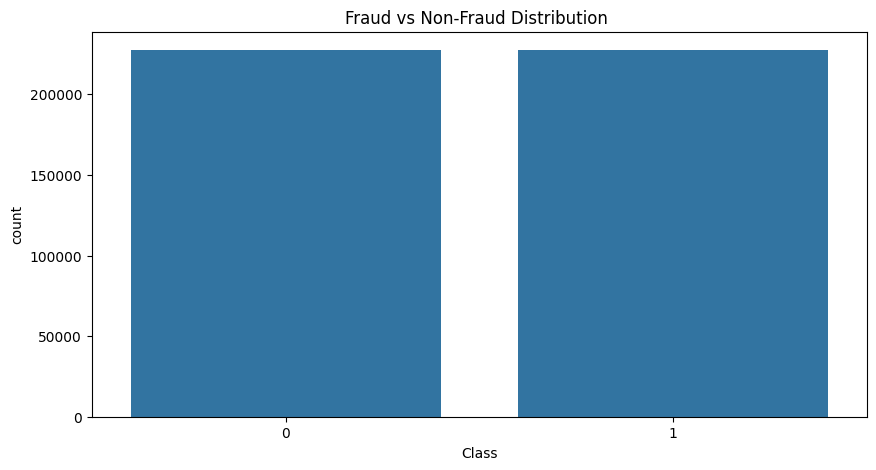

In [15]:
# create a graph to visualize the new data spread
plt.figure(figsize=(10,5))
sns.countplot(x=y_train_smote)
plt.title("Fraud vs Non-Fraud Distribution ")
plt.show()

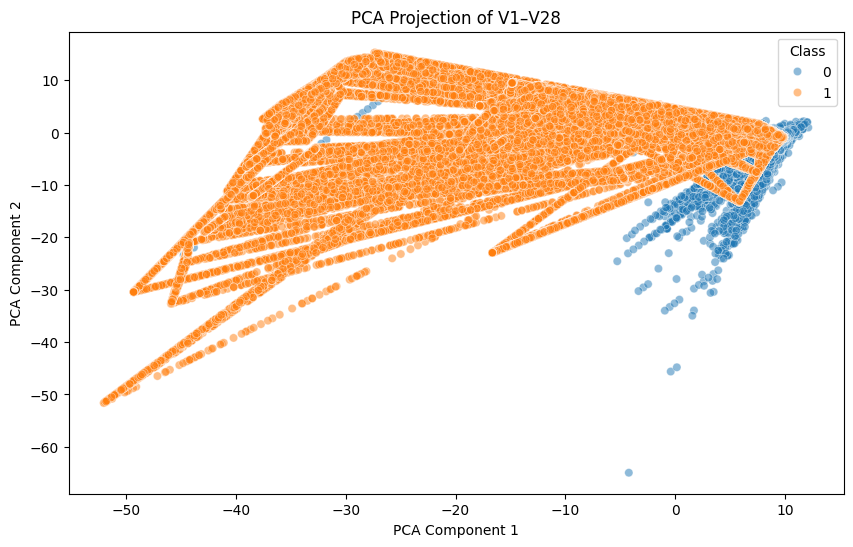

In [16]:
# Create a new graph to visualize the PCA components V1-V28
features = [f'V{i}' for i in range(1, 29)]
X = X_train_smote[features]
y = y_train_smote

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, alpha=0.5)
plt.title('PCA Projection of V1–V28')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## Normalization

In [17]:
# data Standardization
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

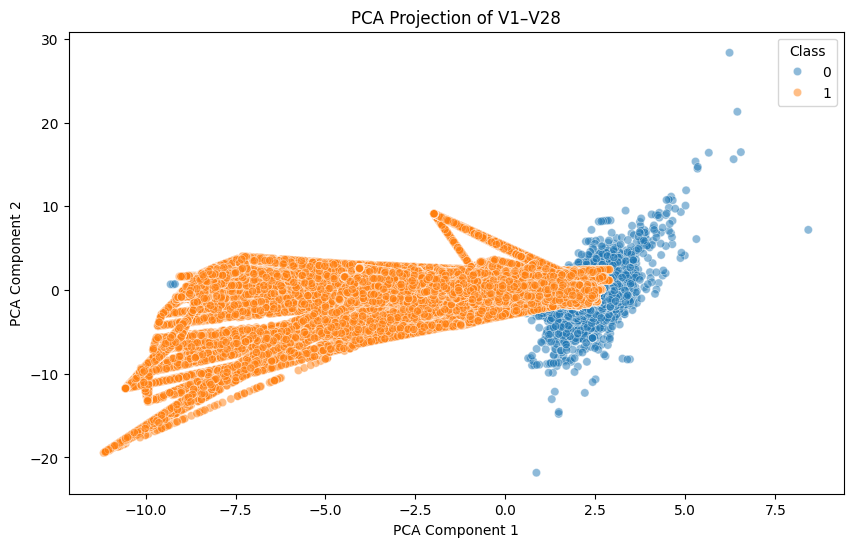

In [18]:
# Create a new graph after normalizing
features = [f'V{i}' for i in range(1, 29)]
X = X_train_smote_scaled
y = y_train_smote

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, alpha=0.5)
plt.title('PCA Projection of V1–V28')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

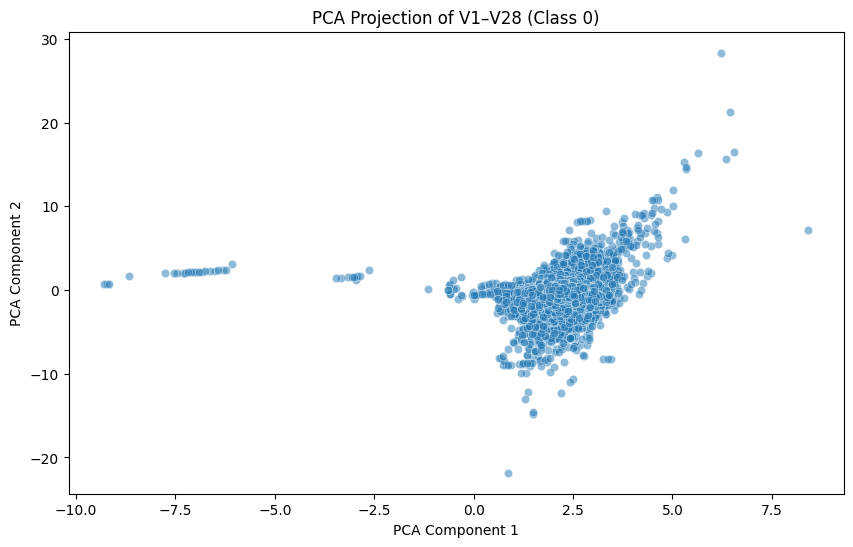

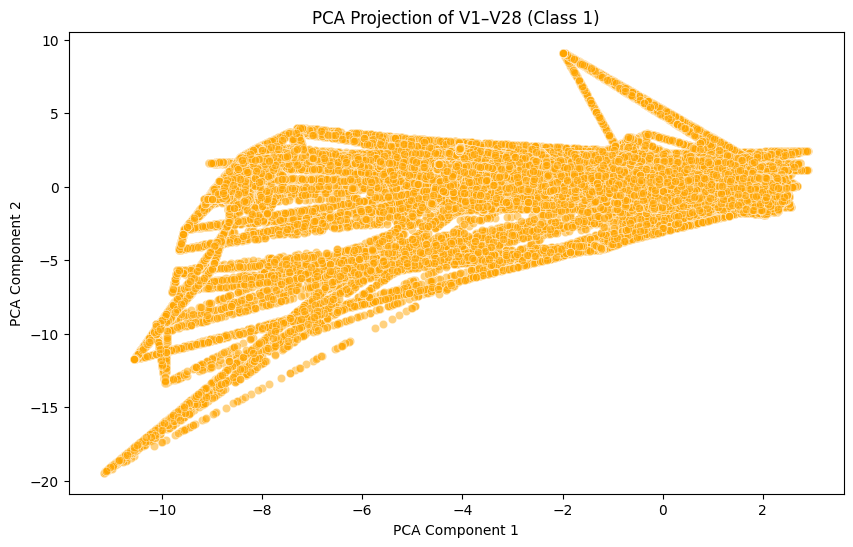

In [19]:
# Create new graphs that show individual data
features = [f'V{i}' for i in range(1, 29)]
X = X_train_smote_scaled
y = y_train_smote

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# --- Graph for Class 0 ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[y == 0, 0], y=X_pca[y == 0, 1], alpha=0.5) # Filter data for class 0
plt.title('PCA Projection of V1–V28 (Class 0)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# --- Graph for Class 1 ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[y == 1, 0], y=X_pca[y == 1, 1], alpha=0.5, color='orange') # Filter data for class 1
plt.title('PCA Projection of V1–V28 (Class 1)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Training Models



Logistic Regression

Random Forest

XGBoost

SVM (RBF kernel)

KNN

## Logistic Regression


Accuracy: 0.9917137740950107
Confusion Matrix:
 [[56400   464]
 [    8    90]]


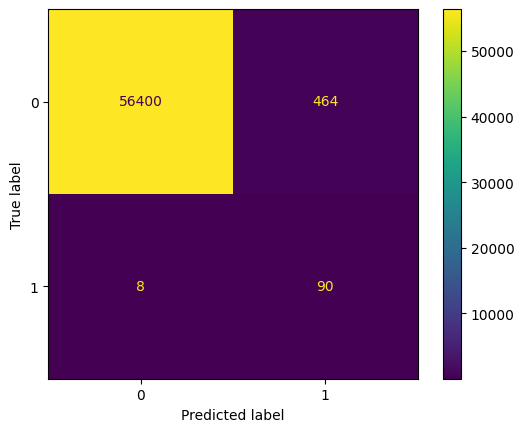

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.16      0.92      0.28        98

    accuracy                           0.99     56962
   macro avg       0.58      0.96      0.64     56962
weighted avg       1.00      0.99      0.99     56962



In [20]:
# Using a Logistic Regression model we will train the data points for classificaiton
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, auc

# train
model = LogisticRegression()
model.fit(X_train_smote_scaled, y_train_smote)

# predict
y_pred = model.predict(X_test_scaled)

# print results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred))

In [21]:
# ROC and PR auc
print("ROC AUC:", roc_auc_score(y_test, y_pred))
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc)

ROC AUC: 0.95510376350878
PR AUC: 0.5404813325459246


The logistic regression model is pretty accurate, with an accuracy score of 0.99 and a recall accuracy of 0.86. There are only 22 improper classifications with this model, as opposed to 8315 proper classifications.

## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# train
model = RandomForestClassifier()
model.fit(X_train_smote_scaled, y_train_smote)

RandomForestClassifier()

Accuracy: 0.9995084442259752
Confusion Matrix:
 [[56852    12]
 [   16    82]]


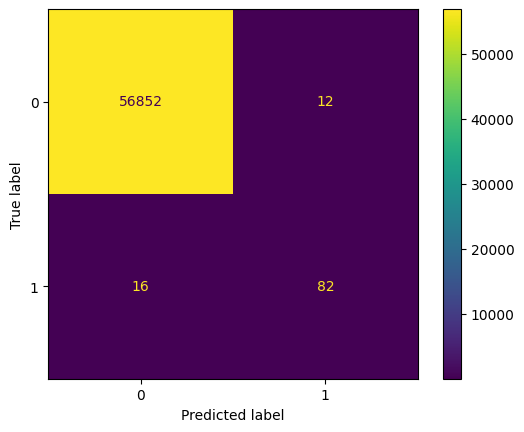

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [24]:
# predict
y_pred_rf = model.predict(X_test_scaled)

# print results
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

In [25]:
# ROC and PR auc
print("ROC AUC:", roc_auc_score(y_test, y_pred_rf))
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_rf)
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc)

ROC AUC: 0.9182618320260012
PR AUC: 0.8546780042115972


The Random Forest model is even more accurate than the logistic regression model, with an accuracy score of 0.998

## Support Vector Machine

In [26]:
# Use an SVM to predict fraud in addition to SMOTE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# train
model = SVC(class_weight='balanced')
model.fit(X_train_smote_scaled, y_train_smote)

SVC(class_weight='balanced')

Accuracy: 0.9973491099329378
Confusion Matrix:
 [[56731   133]
 [   18    80]]


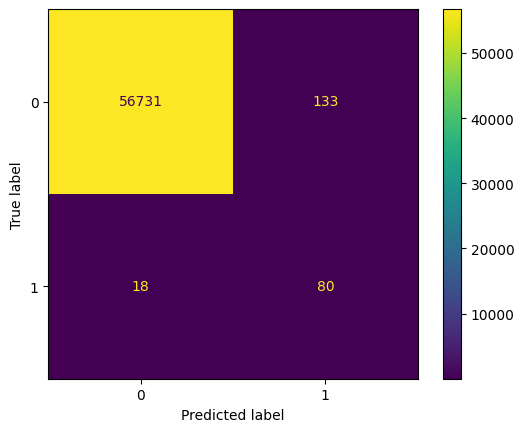

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.38      0.82      0.51        98

    accuracy                           1.00     56962
   macro avg       0.69      0.91      0.76     56962
weighted avg       1.00      1.00      1.00     56962



In [27]:
# predict
y_pred_svm = model.predict(X_test_scaled)

# results
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
cm = confusion_matrix(y_test, y_pred_svm, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

In [29]:
# ROC and PR auc
print("ROC AUC:", roc_auc_score(y_test, y_pred_svm))
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_svm)
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc)

ROC AUC: 0.9069938083562068
PR AUC: 0.5961146926063917


## KNN

In [30]:
# Train using a KNN on the standardized, SMOTE data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Split data
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputation using SimpleImputer for features (X)
imputer = SimpleImputer(strategy='mean')  # Or other strategies like 'median', 'most_frequent'
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Since 'Class' is categorical, we might impute with the most frequent value
from sklearn.impute import SimpleImputer
imputer_y = SimpleImputer(strategy='most_frequent')
y_train = imputer_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = imputer_y.transform(y_test.values.reshape(-1, 1))

# Now use X_train_imputed and X_test_imputed in the KNN model:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_imputed, y_train.ravel()) # use ravel() to avoid warning

# Make Predictions
y_pred_knn = knn_model.predict(X_test_imputed)

Accuracy: 0.9983673326077034
Confusion Matrix:
 [[56864     0]
 [   93     5]]


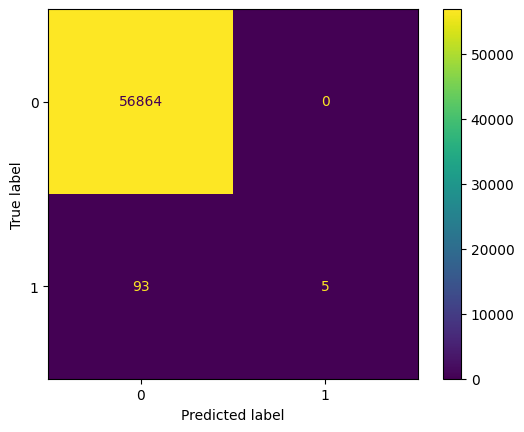

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      0.05      0.10        98

    accuracy                           1.00     56962
   macro avg       1.00      0.53      0.55     56962
weighted avg       1.00      1.00      1.00     56962



In [31]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_knn))

# print results
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_knn, labels=knn_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot()
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

In [32]:
# ROC and PR auc
print("ROC AUC:", roc_auc_score(y_test, y_pred_knn))
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_knn)
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc)

ROC AUC: 0.5255102040816326
PR AUC: 0.5263265377777809


## XGBoost


In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
# train
xg_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xg_model.fit(X_train_smote_scaled, y_train_smote)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:04:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.999420666409185
Confusion Matrix:
 [[56847    17]
 [   16    82]]


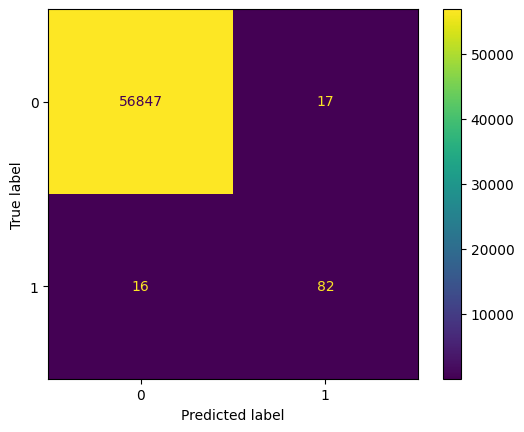

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.84      0.83        98

    accuracy                           1.00     56962
   macro avg       0.91      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [34]:
# predict
y_pred_xg = xg_model.predict(X_test_scaled)

# print results
print("Accuracy:", accuracy_score(y_test, y_pred_xg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xg))
cm = confusion_matrix(y_test, y_pred_xg, labels=xg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xg_model.classes_)
disp.plot()
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred_xg))

In [35]:
# ROC and PR auc
print("ROC AUC:", roc_auc_score(y_test, y_pred_xg))
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_xg)
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc)

ROC AUC: 0.9182178674790119
PR AUC: 0.8326492055870539
